In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

In [2]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [3]:
import pandas as pd

# leave room for other libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read the CSV and Perform Basic Data Cleaning

In [4]:
df = pd.read_csv("exoplanet_data.csv")

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [5]:
# Calculate quantity that each value in koi_disposition
# Since there is a difference between false positive and confirmed/candidate, it affects
# the performance in favor of ML arriving at a model that determines a false positive more frequently
df["koi_disposition"].value_counts()

FALSE POSITIVE    3504
CONFIRMED         1800
CANDIDATE         1687
Name: koi_disposition, dtype: int64

In [6]:
# Focus on columns with koi_fpflag
df.filter(regex='(disposition|_nt|ss|co|_ec)').groupby("koi_disposition").sum()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,,,,
CANDIDATE,0,22,0,0
CONFIRMED,17,21,6,1
FALSE POSITIVE,1081,1668,1413,873


In [7]:
# Names of features
df.columns

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

In [8]:
target = df["koi_disposition"]
target_names = ["candidate", "confirmed", "false positive"]

## Create a Train Test Split
Use koi_disposition for the y values 

In [9]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split
target = df['koi_disposition'].values.reshape(-1, 1)
target_names = ['CANDIDATE','CONFIRMED','FALSE POSITIVE']

# Dropping koi_disposition as target
data = df.drop("koi_disposition", axis=1)
feature_names = data.columns
data.head()

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [10]:
len(data)


6991

## Pre-processing¶
Scale the data using the MinMaxScaler and perform some feature selection

In [11]:
from sklearn.preprocessing import MinMaxScaler
X_minmax = MinMaxScaler().fit(X_train)

X_train_scaled = X_minmax.transform(X_train)
X_test_scaled = X_minmax.transform(X_test)

## Train the Support Vector Machine 

In [12]:
# Support vector machine linear classifier
from sklearn.svm import SVC

In [13]:
model = SVC(kernel='linear')
model.fit(X_train_scaled, np.ravel(y_train,order='C'))

SVC(kernel='linear')

In [14]:
# # Model Accuracy
# print('Test Acc: %.3f' % model.score(X_test, y_test))

In [15]:
# # Null values for teset train split default to test=25, train=75
# X_train, X_test, y_test = train_test_split(X, y, random_state=1, stratify = y)

In [16]:
# X_train.head()

In [17]:
print(f"Training Data Score: {model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model.score(X_test_scaled, y_test)}")

Training Data Score: 0.8455082967766546
Testing Data Score: 0.8415331807780321


                precision    recall  f1-score   support

     CANDIDATE       0.70      0.62      0.66       411
     CONFIRMED       0.71      0.76      0.73       484
FALSE POSITIVE       0.98      1.00      0.99       853

      accuracy                           0.84      1748
     macro avg       0.80      0.79      0.79      1748
  weighted avg       0.84      0.84      0.84      1748



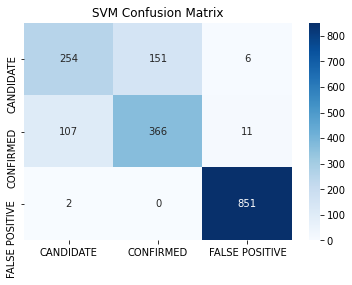

In [18]:
# Calculate classification report
from sklearn.metrics import classification_report, confusion_matrix

# Predicted outcomes
predictions = model.predict(X_test_scaled)

ax= plt.subplot()
cm = (confusion_matrix(y_test,predictions))
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt='g')

# Add labels, title and ticks
ax.set_title('SVM Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
print(classification_report(y_test, predictions))

## Hyperparameter Tuning
Use GridSearchCV to tune the model's parameters

In [19]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1,10,100,1000,10000],
              'gamma': [1,0.1,0.01,0.001,0.0001]}
grid = GridSearchCV(model, param_grid, verbose=3)

In [20]:
# Train the model with GridSearch
grid.fit(X_train_scaled, np.ravel(y_train,order='C'))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=0.1, gamma=1, score=0.841, total=   0.3s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.829, total=   0.3s
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, score=0.835, total=   0.3s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.812, total=   0.3s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.820, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.841, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.829, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.835, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.812, total=   0.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .

[CV] .................... C=10, gamma=0.01, score=0.891, total=   0.3s
[CV] C=10, gamma=0.01 ................................................
[CV] .................... C=10, gamma=0.01, score=0.863, total=   0.3s
[CV] C=10, gamma=0.01 ................................................
[CV] .................... C=10, gamma=0.01, score=0.882, total=   0.3s
[CV] C=10, gamma=0.01 ................................................
[CV] .................... C=10, gamma=0.01, score=0.853, total=   0.2s
[CV] C=10, gamma=0.01 ................................................
[CV] .................... C=10, gamma=0.01, score=0.868, total=   0.3s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................... C=10, gamma=0.001, score=0.891, total=   0.3s
[CV] C=10, gamma=0.001 ...............................................
[CV] ................... C=10, gamma=0.001, score=0.863, total=   0.3s
[CV] C=10, gamma=0.001 ...............................................
[CV] .

[CV] ................. C=1000, gamma=0.001, score=0.877, total=   2.0s
[CV] C=1000, gamma=0.001 .............................................
[CV] ................. C=1000, gamma=0.001, score=0.884, total=   2.5s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.899, total=   2.3s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.886, total=   1.4s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.895, total=   2.6s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.877, total=   2.0s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ................ C=1000, gamma=0.0001, score=0.884, total=   2.5s
[CV] C=10000, gamma=1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.0min finished


GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [21]:
GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [22]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 10000, 'gamma': 1}
0.8889918788522694


In [23]:
model2 = SVC(kernel='linear',C=1000,gamma=1)
model2.fit(X_train_scaled, np.ravel(y_train,order='C'))

SVC(C=1000, gamma=1, kernel='linear')

In [24]:
print(f"Training Data Score: {model2.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model2.score(X_test_scaled, y_test)}")

Training Data Score: 0.8912836162502384
Testing Data Score: 0.8890160183066361


                precision    recall  f1-score   support

     CANDIDATE       0.81      0.72      0.76       411
     CONFIRMED       0.79      0.84      0.81       484
FALSE POSITIVE       0.98      1.00      0.99       853

      accuracy                           0.89      1748
     macro avg       0.86      0.85      0.86      1748
  weighted avg       0.89      0.89      0.89      1748



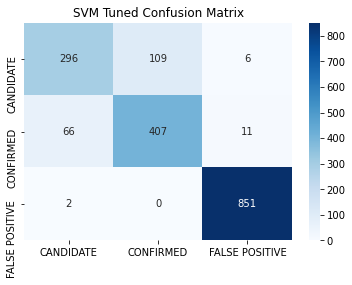

In [25]:
# Predicted outcomes
predictions2 = model2.predict(X_test_scaled)


ax= plt.subplot()
cm = (confusion_matrix(y_test,predictions2))
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt='g') #annot=True to annotate cells

# labels, title and ticks
ax.set_title('SVM Tuned Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
print(classification_report(y_test,predictions2))

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model3 = GaussianNB()
model3.fit(X_train_scaled, np.ravel(y_train))

In [ ]:
print(f"Training Data Score: {model3.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model3.score(X_test_scaled, y_test)}")

In [ ]:
predictions3 = model3.predict(X_test_scaled)


ax= plt.subplot()
cm = (confusion_matrix(y_test,predictions3))
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt='g') #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
print(classification_report(y_test,predictions3))

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier(n_estimators = 500)
model4.fit(X_train_scaled, np.ravel(y_train))

In [ ]:
print(f"Training Data Score: {model4.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model4.score(X_test_scaled, y_test)}")

In [ ]:
# Predicted outcomes
predictions4 = model4.predict(X_test_scaled)


ax= plt.subplot()
cm = (confusion_matrix(y_test,predictions4))
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt='g') #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
print(classification_report(y_test,predictions4))

## Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model5 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model5.fit(X_train_scaled, np.ravel(y_train))

In [ ]:
print(f"Training Data Score: {model5.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model5.score(X_test_scaled, y_test)}")

In [ ]:
predictions5 = model5.predict(X_test_scaled)


ax= plt.subplot()
cm = (confusion_matrix(y_test,predictions5))
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt='g') #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Gradient Boosting Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
print(classification_report(y_test,predictions5))

## K Neighbors

k: 1, Train/Test Score: 1.000/0.790
k: 3, Train/Test Score: 0.897/0.811
k: 5, Train/Test Score: 0.878/0.820
k: 7, Train/Test Score: 0.866/0.823
k: 9, Train/Test Score: 0.856/0.828
k: 11, Train/Test Score: 0.848/0.828
k: 13, Train/Test Score: 0.849/0.822
k: 15, Train/Test Score: 0.841/0.824
k: 17, Train/Test Score: 0.838/0.827
k: 19, Train/Test Score: 0.836/0.824


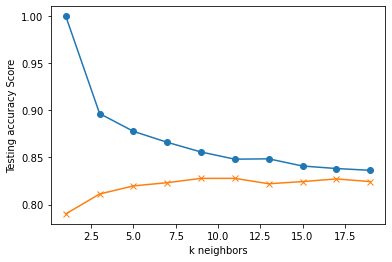

In [28]:
from sklearn.neighbors import KNeighborsClassifier
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, np.ravel(y_train))
    train_score = knn.score(X_train_scaled, np.ravel(y_train))
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [29]:
model6 = KNeighborsClassifier(n_neighbors=5)
model6.fit(X_train_scaled, np.ravel(y_train))

KNeighborsClassifier()

In [30]:
print(f"Training Data Score: {model6.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {model6.score(X_test_scaled, y_test)}")

Training Data Score: 0.8777417509059698
Testing Data Score: 0.8197940503432495


                precision    recall  f1-score   support

     CANDIDATE       0.65      0.56      0.60       411
     CONFIRMED       0.67      0.72      0.70       484
FALSE POSITIVE       0.98      1.00      0.99       853

      accuracy                           0.82      1748
     macro avg       0.77      0.76      0.76      1748
  weighted avg       0.82      0.82      0.82      1748



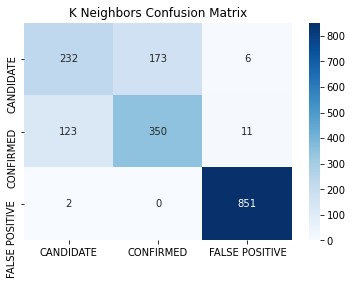

In [31]:
# Predicted outcomes
predictions6 = model6.predict(X_test_scaled)


ax= plt.subplot()
cm = (confusion_matrix(y_test,predictions6))
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues',fmt='g') #annot=True to annotate cells

# labels, title and ticks
ax.set_title('K Neighbors Confusion Matrix')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
print(classification_report(y_test,predictions6))

In [32]:
# preds = [predictions,predictions2,predictions3,predictions4,predictions5,predictions6]
# errors = []
# for pred in preds:
#     err = 0
#     x=0
#     for __ in pred:
#         if y_test[x] != pred[x]:
#             err += 1
#         x += 1
#     errors.append(err)

# df_data = {'Model':['SVM','SVM-Hypertuned','Naive Bayes','Random Forests','Gradient Boosting','K Neighbors'],'Errors':errors}

# df = pd.DataFrame(df_data)
# df

## The Final Model 

In [33]:
df = pd.read_csv("exoplanet_data.csv")

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [34]:
target = pd.get_dummies(df["koi_disposition"])
df = pd.concat([df,target],axis=1)
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,CANDIDATE,CONFIRMED,FALSE POSITIVE
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,1,0
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0,0,1
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0,1
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,0,1,0
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,0,1,0


In [36]:
df.drop(['koi_disposition'],axis=1,inplace=True)
df.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,CANDIDATE,CONFIRMED,FALSE POSITIVE
0,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,...,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,1,0
1,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,...,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0,0,1
2,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,...,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0,1
3,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,...,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,0,1,0
4,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,-0.001900,...,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,0,1,0


In [37]:
# Use train_test_split to create training and testing data
X = df.drop('CANDIDATE',axis=1)
y = df['CANDIDATE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()

In [39]:
logmodel.fit(X_train,y_train)

/Applications/anaconda3/envs/PythonAdv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [40]:
predictions7 = logmodel.predict(X_test)

In [41]:
print(f"Training Data Score: {logmodel.score(X_train, y_train)}")
print(f"Testing Data Score: {logmodel.score(X_test, y_test)}")

Training Data Score: 0.7566278847987793
Testing Data Score: 0.7643020594965675


In [42]:
# Predicted outcomes
predictions7 = logmodel.predict(X_test)

print(classification_report(y_test,predictions7))
print(confusion_matrix(y_test,predictions7))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1337
           1       0.00      0.00      0.00       411

    accuracy                           0.76      1748
   macro avg       0.38      0.50      0.43      1748
weighted avg       0.58      0.76      0.66      1748

[[1336    1]
 [ 411    0]]


In [ ]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
# import joblib
# filename = 'your_name.sav'
# joblib.dump(your_model, filename)